In [1]:
import pandas as pd
df = pd.read_csv('TermLifeData.csv')
df

,MARSTAT,EDUCATION,NUMHH,INCOME,FACE
0,1,16,3,43000,20000
1,1,9,3,12000,130000
2,1,16,5,120000,1500000
3,1,17,4,40000,50000
4,1,15,2,25000,0
...,...,...,...,...,...
495,1,16,4,66000,200000
496,1,12,3,80000,530000
497,0,4,1,5600,0
498,2,12,4,20000,0


In [2]:
df_filtered = df[df['FACE'] >= 50000]
df_filtered

,MARSTAT,EDUCATION,NUMHH,INCOME,FACE
1,1,9,3,12000,130000
2,1,16,5,120000,1500000
3,1,17,4,40000,50000
5,2,11,4,28000,220000
7,1,16,3,100000,600000
...,...,...,...,...,...
479,0,16,3,102000,400000
486,0,17,1,60000,1000000
491,0,17,1,244000,600000
495,1,16,4,66000,200000


<ipython-input-3-f72d27b7d16b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['FACEbc'] = pt.fit_transform(df_filtered[['FACE']])


<AxesSubplot:>

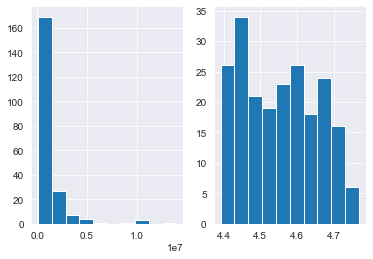

In [3]:
# [a]
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
#df['FACE'].plot(kind='hist')

pt = PowerTransformer(copy=True, method='box-cox', standardize = False)
#afterTransFace = pt.fit_transform(df[['FACE']])
df_filtered['FACEbc'] = pt.fit_transform(df_filtered[['FACE']])
#df['transFACE'].plot(kind='hist')

fig, axes = plt.subplots(1, 2)
df_filtered['FACE'].hist(ax=axes[0])
df_filtered['FACEbc'].hist(ax=axes[1])

In [5]:
import numpy as np
from numpy import log as ln
FACEbc = df_filtered.drop(['FACE'], axis = 1)
FACEbc['FACEbc'] = df_filtered['FACEbc']
FACEbc['INCOME']= ln(FACEbc['INCOME'])
FACEbc['MAR0']= FACEbc['MARSTAT']
FACEbc['MAR0'] = np.where(FACEbc['MAR0'] == 0, 1, 0)
FACEbc['MAR2']= FACEbc['MARSTAT']
FACEbc['MAR2'] = np.where(FACEbc['MAR2'] == 2, 1, 0)
FACEbc.head(15)

,MARSTAT,EDUCATION,NUMHH,INCOME,FACEbc,MAR0,MAR2
1,1,9,3,9.392662,4.489410,0,0
2,1,16,5,11.695247,4.667959,0,0
3,1,17,4,10.596635,4.391879,0,0
5,2,11,4,10.239960,4.535591,0,1
7,1,16,3,11.512925,4.611143,0,0
10,1,17,2,11.626254,4.464478,0,0
11,1,16,4,9.615805,4.695352,0,0
13,0,14,1,10.373491,4.546091,1,0
16,1,12,2,10.126631,4.391879,0,0
18,2,12,6,10.596635,4.454087,0,1


In [15]:
# [b]
import numpy as np

y = df_filtered['FACEbc'].to_numpy()
x = df_filtered.to_numpy()
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
result = reg.fit(FACEbc[['EDUCATION', 'NUMHH', 'INCOME', 'MAR0', 'MAR2']], FACEbc['FACEbc'])
print('intercept: ' + str(reg.intercept_))
print('coefficent: ' + str(reg.coef_))

intercept: 4.054996004855618
coefficent: [ 0.01335962  0.00759392  0.02511296 -0.04642982 -0.01841342]


In [11]:
beta = np.array([reg.coef_[0], reg.coef_[1],reg.coef_[2],reg.coef_[3],reg.coef_[4]]).reshape(5, 1)
#print(beta)
x = FACEbc[['EDUCATION', 'NUMHH', 'INCOME', 'MAR0', 'MAR2']].to_numpy().reshape(213, 5)
#print(x)

In [12]:
#R_sqaure; sigma_hat
import math
fitted_y = np.matmul(x, beta) + np.full((213, 1), reg.intercept_)
y_bar = sum(fitted_y)/len(fitted_y)
n = len(FACEbc)
p = 5
y_matrix_t = FACEbc[['FACEbc']].to_numpy().reshape(1, 213)
y_matrix = FACEbc[['FACEbc']].to_numpy().reshape(213, 1)
fitted_y_matrix_t = fitted_y.reshape(1, 213)
fitted_y_matrix = fitted_y.reshape(213, 1)
TSS = np.matmul(y_matrix_t, y_matrix) - n * (y_bar ** 2)
ESS = np.matmul(y_matrix_t, y_matrix) - np.matmul(y_matrix_t, fitted_y_matrix)
RSS = np.matmul(fitted_y_matrix_t, fitted_y_matrix) - n * (y_bar ** 2)
print(RSS); print(TSS); print(ESS)
R_sqaure = RSS/TSS
sigma_square = ESS/(n-p-1)
sigma_hat = math.sqrt(sigma_square)
print(R_sqaure); print(sigma_hat)

[[0.7536999]]
[[2.25929397]]
[[1.50559407]]
[[0.33359975]]
0.08528423828756308


In [14]:
#[c]
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
#Full
model = ols('FACEbc ~ EDUCATION + NUMHH + INCOME + MAR0 + MAR2', FACEbc).fit()
print(model.summary())
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

                            OLS Regression Results                            
Dep. Variable:                 FACEbc   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     20.72
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           9.13e-17
Time:                        23:42:17   Log-Likelihood:                 225.17
No. Observations:                 213   AIC:                            -438.3
Df Residuals:                     207   BIC:                            -418.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0550      0.060     67.405      0.0

In [13]:
#[c]
import statsmodels.api as sm
from scipy import stats
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 FACEbc   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     20.72
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           9.13e-17
Time:                        23:41:36   Log-Likelihood:                 225.17
No. Observations:                 213   AIC:                            -438.3
Df Residuals:                     207   BIC:                            -418.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0550      0.060     67.405      0.0

In [8]:
# [b & c]
print('R2 = 1')
print('F = 6.790e+20')
print('critical value: 0.05')
print('H0 is fail to rejected')

R2 = 1
F = 6.790e+20
critical value: 0.05
H0 is fail to rejected


In [9]:
# [d]
# FACEbc = β0 + β1EDUCATION + β2NUMHH + β3 ln(INCOME) + β4MAR0 + β5MAR2 + e

pred = 4.2170313639659565 + 3.22*16 + 3.691*4 + 9.194*np.log(120000) + 0 + 1*2
print('Prediction Amount: ' + str(pred))
print('Prediction interval: '+ str(reg.coef_))

Prediction Amount: 180.0271324820659
Prediction interval: [0.01933503 0.01576345]
